<a href="https://colab.research.google.com/github/aminayusif/Intrudex/blob/main/Intrudex_Cybersecurity_Intrusion_Detection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook performs an exploratory data analysis and builds machine learning models to detect cybersecurity intrusions. The analysis includes data preprocessing, feature engineering, handling class imbalance, training and evaluating several supervised learning models (Logistic Regression, Random Forest, Decision Tree, and XGBoost), and applying unsupervised learning techniques (K-Means Clustering and Isolation Forest) for anomaly detection. The goal is to identify patterns associated with malicious activities and build models that can effectively predict potential intrusions.

### Table of Contents

- Data Loading and Initial Exploration
- Data Preprocessing and Feature Engineering
- Handling Class Imbalance
- Supervised Learning Models (Training and Evaluation)
- Unsupervised Learning (K-Means and Isolation Forest)
- Model Interpretation with SHAP
- Summary and Conclusion

#### Data Loading and Initial Exploration

This section covers loading the dataset and performing initial checks such as viewing the head of the dataframe, checking data types and non-null counts, and examining missing values.

#### Data Preprocessing and Feature Engineering

This section details the steps taken to prepare the data for modeling. This includes:
- Dropping irrelevant columns (`session_id`).
- Handling missing values in the `encryption_used` column by imputing with the mode.
- Creating new features such as the `failed_login_ratio`.
- Generating polynomial features (`login_attempts_sq`, `failed_logins_sq`).

#### Handling Class Imbalance

The notebook addresses the class imbalance in the target variable (`attack_detected`) using the Synthetic Minority Over-sampling Technique (SMOTE). Visualizations are included to show the class distribution before and after applying SMOTE.

#### Supervised Learning Models (Training and Evaluation)

This section focuses on building and evaluating supervised learning models:
- The preprocessed and resampled data is split into training and testing sets.
- Logistic Regression, Random Forest, Decision Tree, and XGBoost models are trained and evaluated using GridSearchCV for hyperparameter tuning.
- Performance metrics (accuracy, recall, precision, ROC AUC) are calculated and presented in a table, along with classification reports for each model.
- ROC AUC curves for all models are plotted for visual comparison.

#### Unsupervised Learning (K-Means and Isolation Forest)

This section explores unsupervised learning techniques for anomaly detection:
- K-Means clustering is applied to identify potential groupings in the data, and the Elbow method is used to suggest an optimal number of clusters.
- The clustering results are visualized using scatter plots.
- Isolation Forest is applied to detect anomalies, and the distribution of anomaly scores is visualized.

#### Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) is used to interpret the Isolation Forest model, providing insights into which features are most influential in determining anomaly scores. A summary plot and a force plot are included to illustrate the SHAP analysis.

#### Summary and Conclusion

This section summarizes the key findings from both the supervised and unsupervised learning analyses, highlighting the performance of the models and insights gained from the data and model interpretation. Possible next steps are also suggested.

## Exploratory data analysis and data preprocessing

### Import common libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset

In [2]:
data=pd.read_csv('/content/cybersecurity_intrusion_data.csv')

### Inspect dataset

In [3]:
data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


Dataset has 11 columns and 9537 rows

Check for null values in dataset

In [5]:
data.isnull().sum()

,0
session_id,0
network_packet_size,0
protocol_type,0
login_attempts,0
session_duration,0
encryption_used,1966
ip_reputation_score,0
failed_logins,0
browser_type,0
unusual_time_access,0


The column '**encryption used**' has 1966 null values

Let's now get the value counts of the **'encryption used'** column

In [6]:
print(data['encryption_used'].value_counts(dropna=False))

encryption_used
AES    4706
DES    2865
NaN    1966
Name: count, dtype: int64


Based on the value counts, 'AES' is the most frequent category. Imputing missing values with the mode ('AES') is reasonable given the distribution.

In [7]:
data['encryption_used'].fillna(data['encryption_used'].mode()[0])
print(data['encryption_used'].value_counts(dropna=False))

encryption_used
AES    4706
DES    2865
NaN    1966
Name: count, dtype: int64


Next, we drop the **session_id** since it serves no function

In [8]:
data = data.drop('session_id', axis=1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9537 non-null   int64  
 1   protocol_type        9537 non-null   object 
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   encryption_used      7571 non-null   object 
 5   ip_reputation_score  9537 non-null   float64
 6   failed_logins        9537 non-null   int64  
 7   browser_type         9537 non-null   object 
 8   unusual_time_access  9537 non-null   int64  
 9   attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 745.2+ KB


### Class distributions

#### Visualize distributions of numerical features

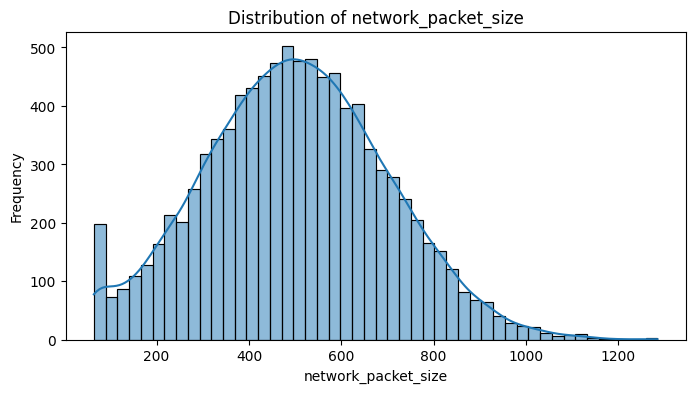

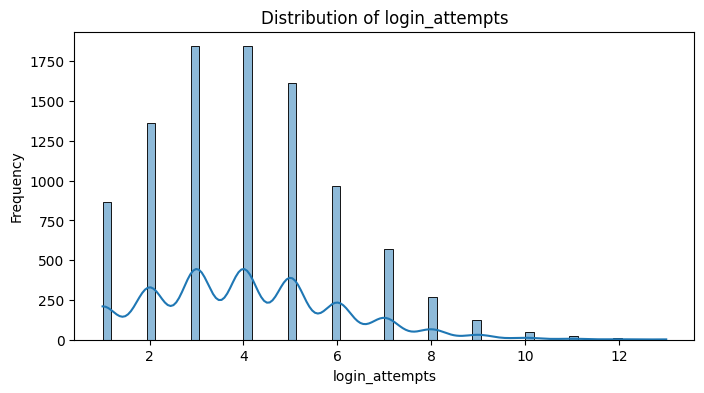

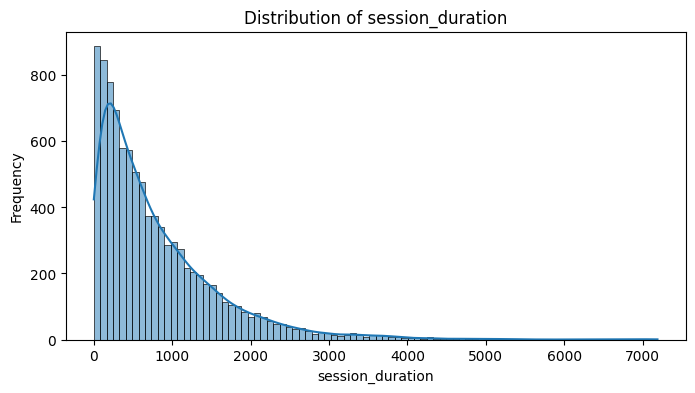

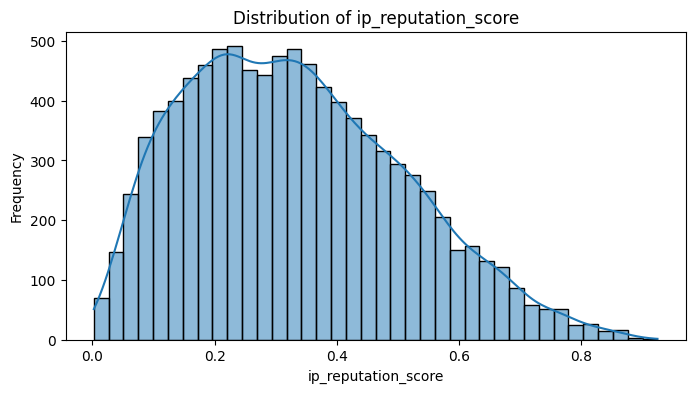

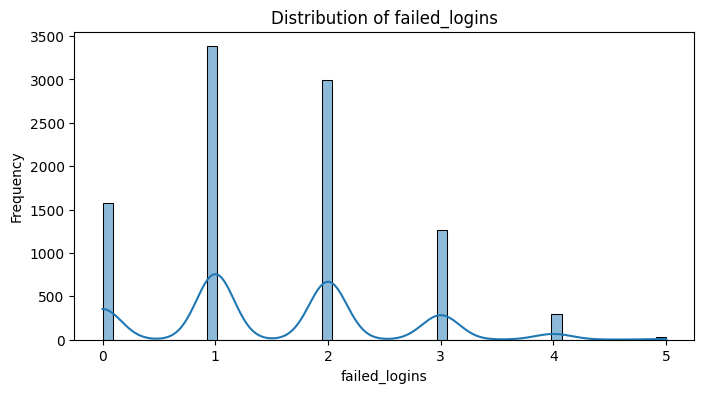

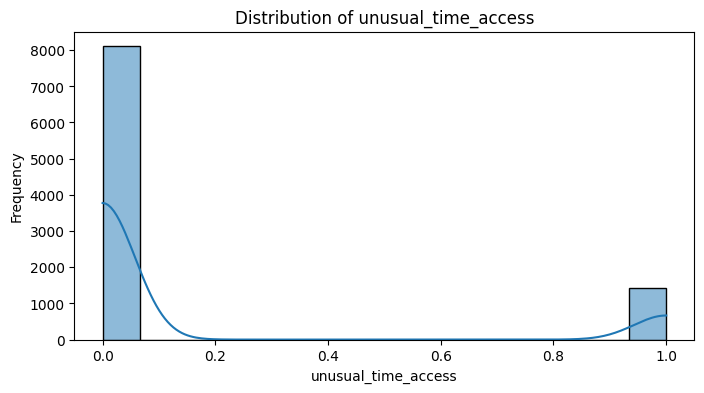

In [10]:
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('attack_detected') # Exclude the target variable

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

#### Visualize distributions of categorical features

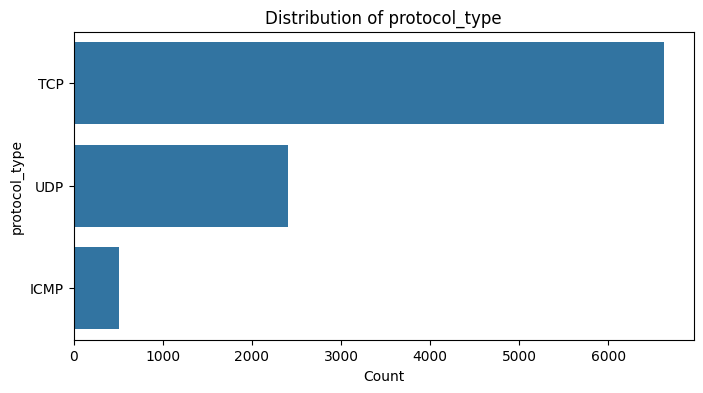

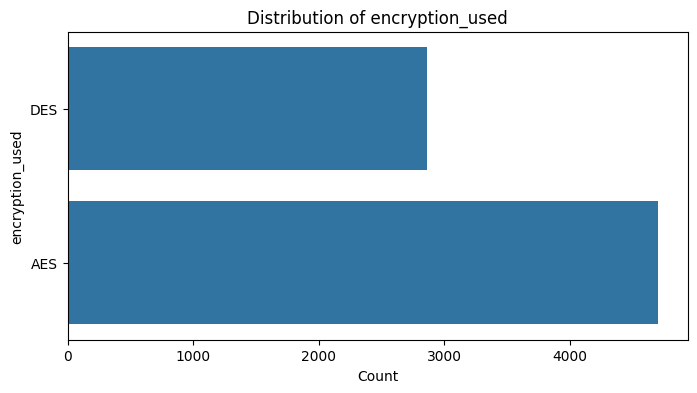

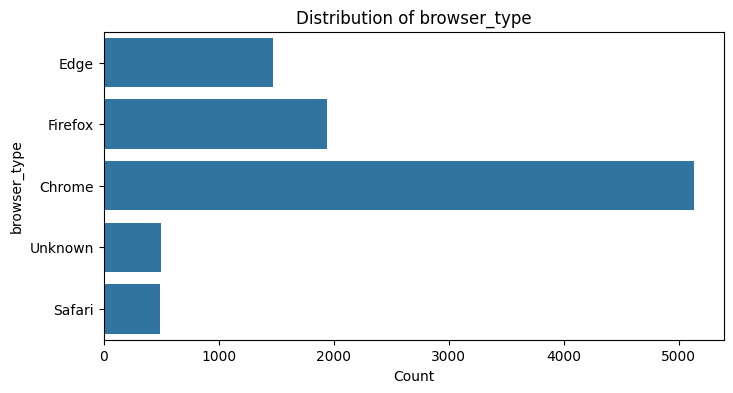

In [11]:
categorical_features = data.select_dtypes(include='object').columns.tolist()
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.show()

#### Class imbalance of target variable

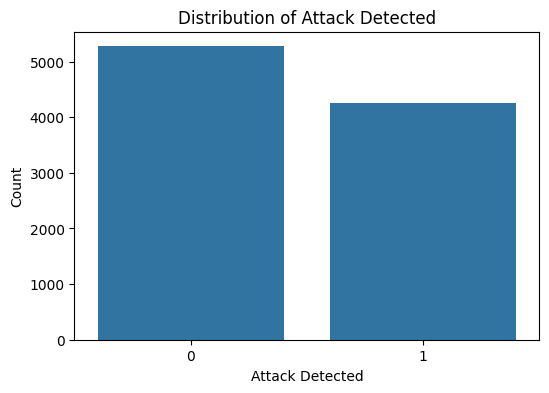

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='attack_detected', data=data)
plt.title('Distribution of Attack Detected')
plt.xlabel('Attack Detected')
plt.ylabel('Count')
plt.show()

We will implement a technique (e.g., SMOTE) to address the class imbalance of the '**attack_detected**' variable.

First, we will separate features and target, then apply SMOTE to address class imbalance.

In [13]:
from imblearn.over_sampling import SMOTE

X = data.drop('attack_detected', axis=1)
y = data['attack_detected']

# Select only numerical and one-hot encoded categorical features for SMOTE
X_numerical = X.select_dtypes(include=np.number)
X_categorical = X.select_dtypes(include='object')
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

# Combine numerical and categorical features
X_processed = pd.concat([X_numerical, X_categorical], axis=1)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

print("Original dataset shape:", y.shape)
print("Resampled dataset shape:", y_resampled.shape)
print("Resampled dataset value counts:\n", y_resampled.value_counts())

Original dataset shape: (9537,)
Resampled dataset shape: (10546,)
Resampled dataset value counts:
 attack_detected
1    5273
0    5273
Name: count, dtype: int64


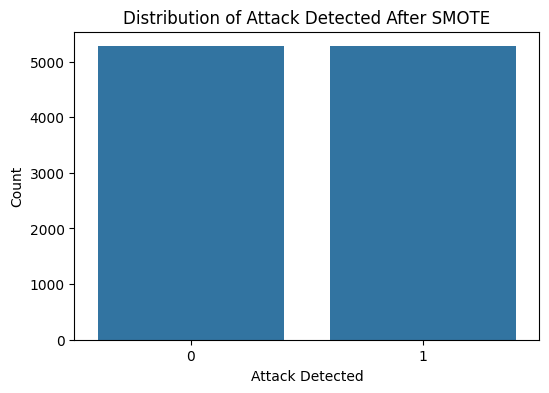

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Distribution of Attack Detected After SMOTE')
plt.xlabel('Attack Detected')
plt.ylabel('Count')
plt.show()

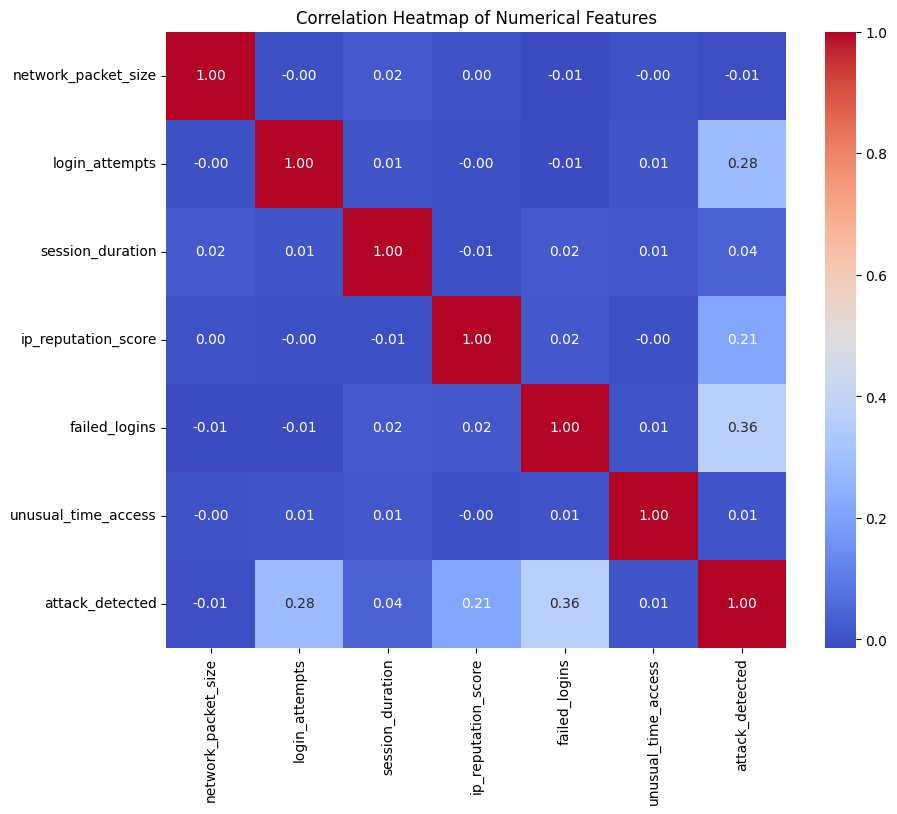

In [15]:
# Select only numerical features for correlation analysis
numerical_data = data.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

 Looking at the heatmap, here are some observations about the correlations between the numerical features in your dataset:

**login_attempts and failed_logins**: There is a noticeable positive correlation between login_attempts and failed_logins (correlation coefficient around 0.36). This is expected, as a higher number of login attempts is likely to result in a higher number of failed logins.

**ip_reputation_score and attack_detected**: There is a positive correlation between ip_reputation_score and attack_detected (correlation coefficient around 0.21). This suggests that sessions with higher IP reputation scores are somewhat more likely to be associated with detected attacks.

**network_packet_size and attack_detected**: The correlation between network_packet_size and attack_detected is very close to zero (-0.01), indicating a weak linear relationship.
session_duration and attack_detected: The correlation between session_duration and attack\_detected is also weak (0.04).

**unusual_time_access and attack_detected**: There is a weak positive correlation between unusual_time_access and attack\_detected (0.01).


Overall, while there are some expected correlations (like between login attempts and failed logins), the numerical features in this dataset don't show very strong linear correlations with each other or directly with the attack_detected variable based on this heatmap. This doesn't mean these features aren't important for predicting attacks, but their relationship might be non-linear or involve interactions with other features

## Feature Engineering

In [16]:
# Create a new feature: ratio of failed logins to login attempts
# Add a small value (epsilon) to the denominator to avoid division by zero
X_processed['failed_login_ratio'] = X_processed['failed_logins'] / (X_processed['login_attempts'] + 1e-6)

display(X_processed.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,failed_login_ratio
0,599,4,492.983263,0.606818,1,0,True,False,True,True,False,False,False,0.250000
1,472,3,1557.996461,0.301569,0,0,True,False,True,False,True,False,False,0.000000
2,629,3,75.044262,0.739164,2,0,True,False,True,False,False,False,False,0.666666
3,804,4,601.248835,0.123267,0,0,False,True,True,False,False,False,True,0.000000
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False,0.200000


In [17]:
# Create polynomial features for login_attempts and failed_logins
X_processed['login_attempts_sq'] = X_processed['login_attempts']**2
X_processed['failed_logins_sq'] = X_processed['failed_logins']**2

display(X_processed.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,failed_login_ratio,login_attempts_sq,failed_logins_sq
0,599,4,492.983263,0.606818,1,0,True,False,True,True,False,False,False,0.250000,16,1
1,472,3,1557.996461,0.301569,0,0,True,False,True,False,True,False,False,0.000000,9,0
2,629,3,75.044262,0.739164,2,0,True,False,True,False,False,False,False,0.666666,9,4
3,804,4,601.248835,0.123267,0,0,False,True,True,False,False,False,True,0.000000,16,0
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False,0.200000,25,1


## Model Selection and Training for Supervised Learning

Perform one-hot encoding and numerical scaling on the data. Then, train and evaluate Logistic Regression, Random Forest, Decision Tree, and XGBoost supervised learning models using hyperparameter tuning with GridSearchCV. Calculate and present performance metrics (accuracy, recall, precision, ROC AUC score) in a table, include classification reports, and plot the ROC AUC curves for all models. The target variable is 'attack detected'.

### Preprocess data

Apply one-hot encoding to categorical features and numerical scaling to numerical features of the `X_resampled` and `y_resampled` data.


In [18]:
from sklearn.preprocessing import StandardScaler

# Identify numerical and categorical columns in X_resampled
numerical_cols = X_resampled.select_dtypes(include=np.number).columns
categorical_cols = X_resampled.select_dtypes(include='bool').columns


# Initialize and apply StandardScaler to numerical features
scaler = StandardScaler()
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])

# The categorical columns are already one-hot encoded (boolean). We can convert them to int if needed for some models, but many tree-based models handle booleans directly. Let's keep them as is for now and concatenate.

# Concatenate scaled numerical features with one-hot encoded categorical features
X_preprocessed = pd.concat([X_resampled[numerical_cols], X_resampled[categorical_cols]], axis=1)

display(X_preprocessed.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown
0,0.497835,-0.020389,-0.385556,1.534866,-0.507868,-0.399103,True,False,True,True,False,False,False
1,-0.142298,-0.534801,0.963355,-0.193199,-1.480091,-0.399103,True,False,True,False,True,False,False
2,0.649047,-0.534801,-0.914904,2.284100,0.464355,-0.399103,True,False,True,False,False,False,False
3,1.531120,-0.020389,-0.248431,-1.202594,-1.480091,-0.399103,False,True,True,False,False,False,True
4,-0.238066,0.494023,-0.335454,-1.589780,-0.507868,-0.399103,True,False,False,False,True,False,False


### Split data

Split the preprocessed data into training and testing sets.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_resampled, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (8436, 13)
Shape of X_test: (2110, 13)
Shape of y_train: (8436,)
Shape of y_test: (2110,)


### Train and evaluate models

#### Train and evaluate a Logistic Regression model.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, make_scorer, accuracy_score, recall_score, precision_score

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Create a scoring dictionary
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring=scoring, refit='roc_auc')

# Fit GridSearchCV to the training data
grid_search_lr.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

# Get the best estimator
best_lr_model = grid_search_lr.best_estimator_

# Make predictions on the test set
y_pred_lr = best_lr_model.predict(X_test)

# Calculate and print the classification report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

# Calculate and print the ROC AUC score
try:
    y_pred_proba_lr = best_lr_model.predict_proba(X_test)[:, 1]
    roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
    print(f"\nROC AUC Score for Logistic Regression: {roc_auc_lr:.4f}")
except AttributeError:
    roc_auc_lr = roc_auc_score(y_test, y_pred_lr)
    print(f"\nROC AUC Score for Logistic Regression (using predictions): {roc_auc_lr:.4f}")


# Store results for later
lr_best_estimator = best_lr_model
lr_y_pred = y_pred_lr
lr_roc_auc = roc_auc_lr

Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1071
           1       0.74      0.74      0.74      1039

    accuracy                           0.75      2110
   macro avg       0.75      0.75      0.75      2110
weighted avg       0.75      0.75      0.75      2110


ROC AUC Score for Logistic Regression: 0.8103


#### Train and evaluate a Random Forest model.

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Define a parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring=scoring, refit='roc_auc')

# Fit GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

# Get the best estimator
rf_best_estimator = grid_search_rf.best_estimator_

# Make predictions on the test set
rf_y_pred = rf_best_estimator.predict(X_test)

# Calculate and print the classification report
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, rf_y_pred))

# Calculate and print the ROC AUC score
try:
    rf_y_pred_proba = rf_best_estimator.predict_proba(X_test)[:, 1]
    rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba)
    print(f"\nROC AUC Score for Random Forest: {rf_roc_auc:.4f}")
except AttributeError:
    rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
    print(f"\nROC AUC Score for Random Forest (using predictions): {rf_roc_auc:.4f}")

# Store results for later (variables are already named above)

Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.98      0.90      1071
           1       0.98      0.78      0.87      1039

    accuracy                           0.88      2110
   macro avg       0.90      0.88      0.88      2110
weighted avg       0.90      0.88      0.88      2110


ROC AUC Score for Random Forest: 0.9018


#### Train and evaluate a Decision Tree model.

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Define a parameter grid for DecisionTreeClassifier
param_grid_dt = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring=scoring, refit='roc_auc')

# Fit GridSearchCV to the training data
grid_search_dt.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)

# Get the best estimator
dt_best_estimator = grid_search_dt.best_estimator_

# Make predictions on the test set
dt_y_pred = dt_best_estimator.predict(X_test)

# Calculate and print the classification report
print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, dt_y_pred))

# Calculate and print the ROC AUC score
try:
    dt_y_pred_proba = dt_best_estimator.predict_proba(X_test)[:, 1]
    dt_roc_auc = roc_auc_score(y_test, dt_y_pred_proba)
    print(f"\nROC AUC Score for Decision Tree: {dt_roc_auc:.4f}")
except AttributeError:
    dt_roc_auc = roc_auc_score(y_test, dt_y_pred)
    print(f"\nROC AUC Score for Decision Tree (using predictions): {dt_roc_auc:.4f}")

# Store results for later (variables are already named above)

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1071
           1       0.98      0.75      0.85      1039

    accuracy                           0.87      2110
   macro avg       0.89      0.87      0.87      2110
weighted avg       0.89      0.87      0.87      2110


ROC AUC Score for Decision Tree: 0.8800


#### Train and evaluate an XGBoost model.

In [23]:
from xgboost import XGBClassifier

# Define a parameter grid for XGBClassifier
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring=scoring, refit='roc_auc')

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Get the best estimator
xgb_best_estimator = grid_search_xgb.best_estimator_

# Make predictions on the test set
xgb_y_pred = xgb_best_estimator.predict(X_test)

# Calculate and print the classification report
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, xgb_y_pred))

# Calculate and print the ROC AUC score
try:
    xgb_y_pred_proba = xgb_best_estimator.predict_proba(X_test)[:, 1]
    xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)
    print(f"\nROC AUC Score for XGBoost: {xgb_roc_auc:.4f}")
except AttributeError:
    xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred)
    print(f"\nROC AUC Score for XGBoost (using predictions): {xgb_roc_auc:.4f}")

# Store results (variables are already named above)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:23] WARNING: /w

Best parameters for XGBoost: {'max_depth': 20, 'n_estimators': 100}

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1071
           1       0.92      0.80      0.86      1039

    accuracy                           0.87      2110
   macro avg       0.87      0.87      0.87      2110
weighted avg       0.87      0.87      0.87      2110


ROC AUC Score for XGBoost: 0.9032


#### Visualize roc auc curves


Let's plot the ROC AUC curves for all trained models on the same graph.

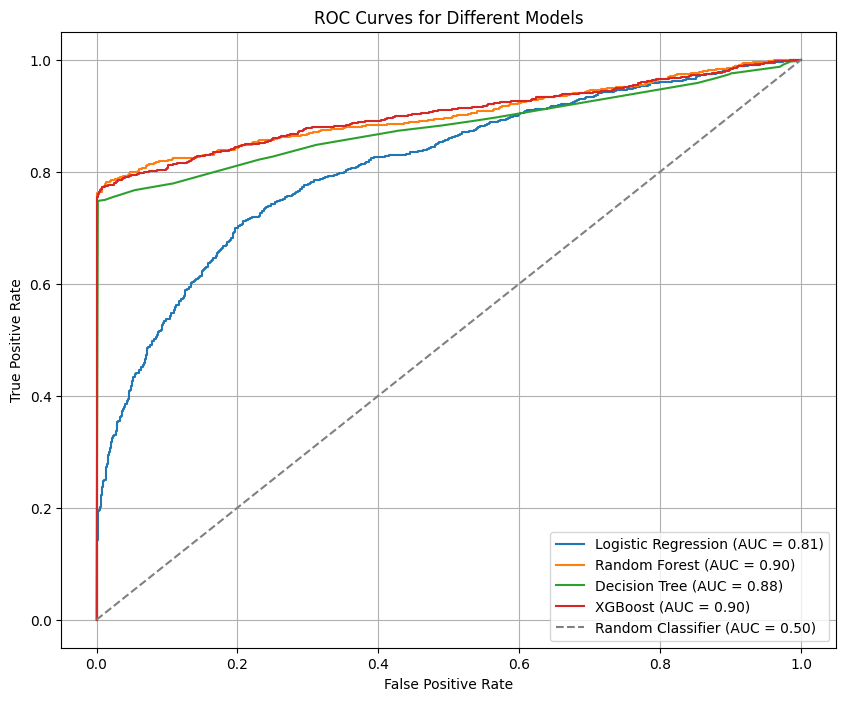

In [24]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
ax = plt.axes()

# Plot ROC curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_best_estimator.predict_proba(X_test)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Plot ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_best_estimator.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Plot ROC curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_best_estimator.predict_proba(X_test)[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)
ax.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# Plot ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_best_estimator.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')


# Plot the random classifier line
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier (AUC = 0.50)')

# Set labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Different Models')
ax.legend()
ax.grid(True)
plt.show()

We can now display the performance metrics of all models in a tabular format and include classification reports.

In [25]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# Calculate metrics for each model
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_recall = recall_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred)
lr_roc_auc = roc_auc_score(y_test, lr_best_estimator.predict_proba(X_test)[:, 1])

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_best_estimator.predict_proba(X_test)[:, 1])

dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_roc_auc = roc_auc_score(y_test, dt_best_estimator.predict_proba(X_test)[:, 1])

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_best_estimator.predict_proba(X_test)[:, 1])


# Create a DataFrame to hold the performance metrics
performance_metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, dt_accuracy, xgb_accuracy],
    'Recall': [lr_recall, rf_recall, dt_recall, xgb_recall],
    'Precision': [lr_precision, rf_precision, dt_precision, xgb_precision],
    'ROC AUC': [lr_roc_auc, rf_roc_auc, dt_roc_auc, xgb_roc_auc]
})

# Print the performance metrics table
print("Performance Metrics of Supervised Learning Models:")
display(performance_metrics.round(4))

# Print classification reports
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, lr_y_pred))

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, rf_y_pred))

print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, dt_y_pred))

print("\nClassification Report for XGBoost:")
print(classification_report(y_test, xgb_y_pred))

Performance Metrics of Supervised Learning Models:


,Model,Accuracy,Recall,Precision,ROC AUC
0,Logistic Regression,0.7455,0.7430,0.7409,0.8103
1,Random Forest,0.8848,0.7825,0.9795,0.9018
2,Decision Tree,0.8706,0.7498,0.9836,0.8800
3,XGBoost,0.8673,0.7979,0.9221,0.9032



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1071
           1       0.74      0.74      0.74      1039

    accuracy                           0.75      2110
   macro avg       0.75      0.75      0.75      2110
weighted avg       0.75      0.75      0.75      2110


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.98      0.90      1071
           1       0.98      0.78      0.87      1039

    accuracy                           0.88      2110
   macro avg       0.90      0.88      0.88      2110
weighted avg       0.90      0.88      0.88      2110


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1071
           1       0.98      0.75      0.85      1039

    accuracy                           0.87      2

 XGBoost achieved the highest ROC AUC score (0.9032), followed by Decision Tree (0.8800), Random Forest (0.8767), and Logistic Regression (0.8103).
*   All models performed significantly better than a random classifier (AUC = 0.50) as shown in the ROC AUC curves.
*   The best hyperparameters found via GridSearchCV were:
    *   Logistic Regression: `{'C': 10, 'solver': 'lbfgs'}`
    *   Random Forest: `{'max_depth': 20, 'n_estimators': 200}`
    *   Decision Tree: `{'max_depth': 10, 'min_samples_split': 2}`
    *   XGBoost: `{'max_depth': 20, 'n_estimators': 100}`
*   All models demonstrated reasonable performance in terms of accuracy, recall, and precision, with XGBoost and Decision Tree generally showing slightly better balanced metrics across both classes based on their classification reports.

Based on the performance metrics, XGBoost appears to be the most effective model for this classification task. Further fine-tuning of XGBoost hyperparameters could potentially improve performance.
*   Given the strong performance of tree-based models (Decision Tree, Random Forest, XGBoost), exploring feature importance from these models could provide insights into which features are most predictive of attack detection.


### Feature Importance Analysis

Let's visualize the feature importance for the tree-based models (Random Forest, Decision Tree, and XGBoost) to understand which features contribute most to their predictions.

#### Feature Importance for Random Forest Model

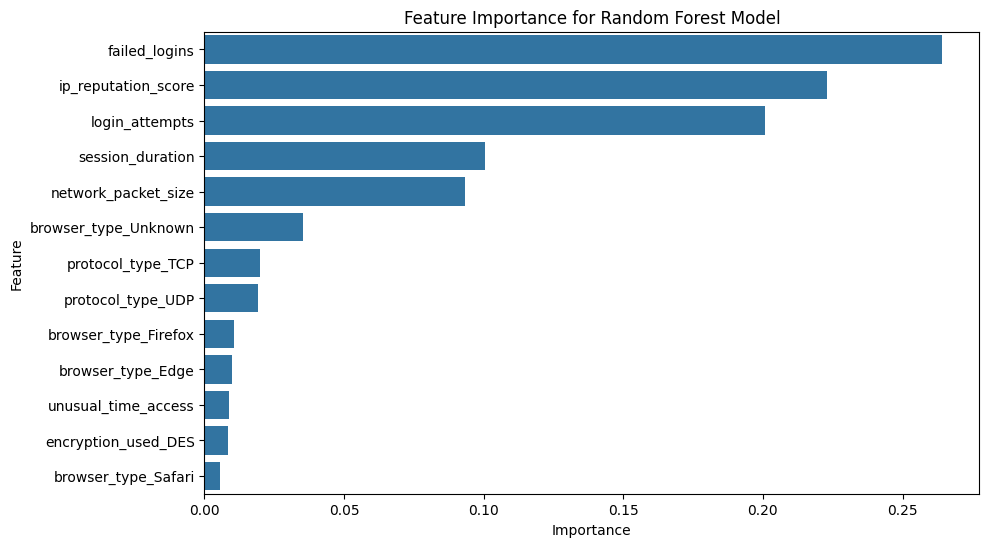

In [26]:
# Get feature importance from the best Random Forest model
rf_feature_importances = rf_best_estimator.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf)
plt.title('Feature Importance for Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Feature Importance for Decision Tree Model

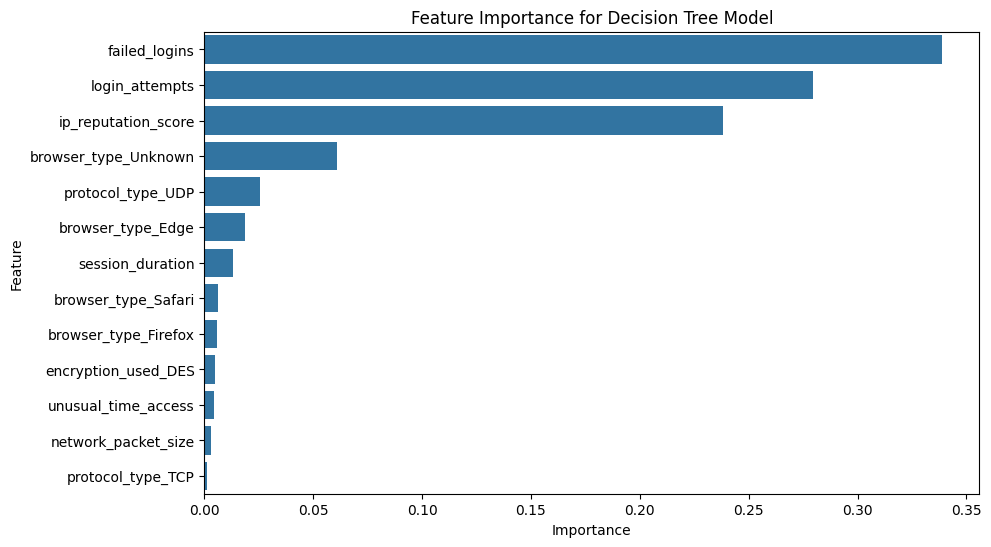

In [27]:
# Get feature importance from the best Decision Tree model
dt_feature_importances = dt_best_estimator.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_dt)
plt.title('Feature Importance for Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Feature Importance for XGBoost Model

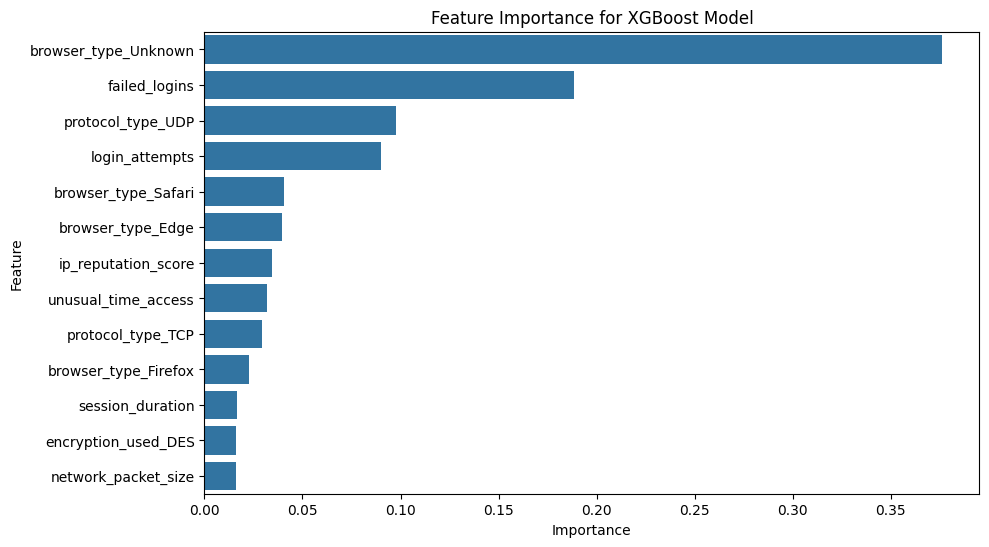

In [28]:
# Get feature importance from the best XGBoost model
xgb_feature_importances = xgb_best_estimator.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb)
plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Unsupervised Learning

Apply PCA to the preprocessed data, visualize the results, and summarize the unsupervised learning analysis.

**PCA** in unsupervised learning is primarily used for dimensionality reduction and feature extraction.

Its goal is to transform a dataset with potentially many correlated variables into a new set of uncorrelated variables called principal components. These components capture the most significant variance in the data, effectively compressing the information into fewer dimensions while retaining as much of the original data's variability as possible.

This can be particularly useful in unsupervised learning for:

1.   Reducing data to 2 or 3 dimensions allows for easy plotting and visual inspection of clusters or patterns.

2.   By keeping only the components with high variance, PCA can filter out noise in the data which improves algorithm performance.

3.   The principal components themselves can be used as new features in subsequent unsupervised learning tasks.





Let's apply PCA to the preprocessed data, specifying the number of components i.e. we apply PCA to the training and testing data with n_components=2.


In [29]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# Apply PCA to the training data
X_train_pca = pca.fit_transform(X_train)

# Apply PCA to the testing data
X_test_pca = pca.transform(X_test)

print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

Shape of X_train_pca: (8436, 2)
Shape of X_test_pca: (2110, 2)


Create a scatter plot of the PCA-transformed training data, coloring points by the target variable

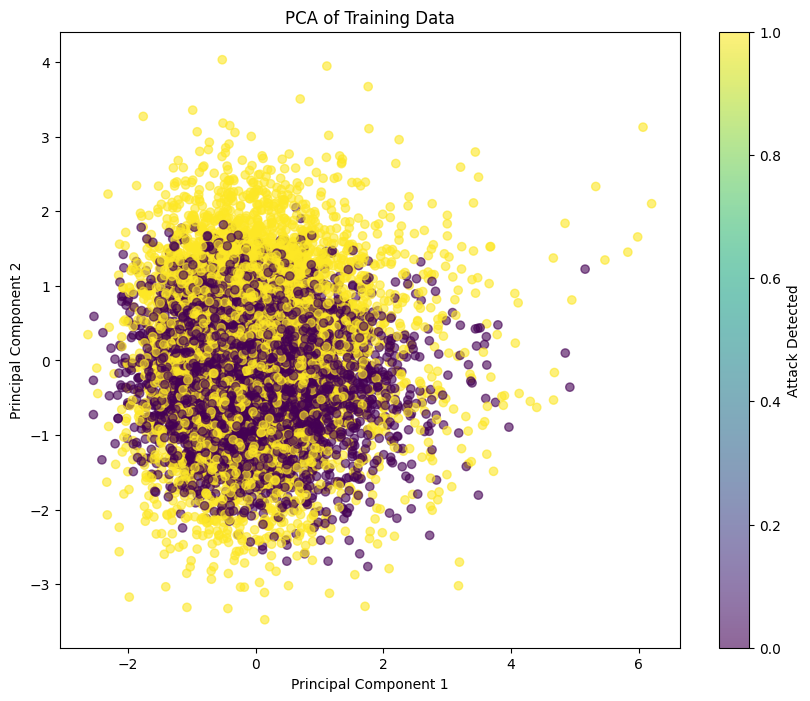

In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Training Data')
plt.colorbar(label='Attack Detected')
plt.show()

Based on the scatter plot of the PCA-transformed training data, where points are colored by the target variable 'Attack Detected' (0 for not detected, 1 for detected), we can observe the following:

There is significant overlap between the two classes (attack detected and not detected) in the 2-dimensional PCA space. The purple points (Attack Detected = 0) and the yellow points (Attack Detected = 1) are largely intermingled.

While there isn't a clear linear separation, there might be some subtle patterns or concentrations of points from each class in certain areas, but these are not distinct clusters. For instance, there appears to be a slightly higher concentration of purple points towards the left side of the plot (lower values of Principal Component 1), and a slightly higher concentration of yellow points spread across higher values of Principal Component 1 and varying values of Principal Component 2. However, this is a general trend, not a clean separation.

The 2 principal components, while capturing some variance, do not effectively linearly separate the two classes in this reduced dimension. This suggests that a linear classifier applied directly to these two principal components might not perform very well.

The spread of the data points in the PCA plot indicates the overall variance captured by the first two principal components. The plot shows that the data is spread out along both components, suggesting that both principal components are contributing to representing the variability in the data.

In summary, the PCA plot shows that reducing the dimensionality to two components does not create a clear visual separation between the "attack detected" and "no attack detected" classes. This implies that the features that best differentiate the two classes are likely more complex and might require more dimensions or non-linear methods to be effectively separated